# 5. Análise de comunidades por casa legislativa

## 5.1. Preparação

### 5.1.1. Imports

In [1]:

import os

from pathlib import Path
from collections import defaultdict
import itertools
import duckdb
import numpy as np
import pandas as pd
import igraph as ig
import seaborn as sns
from event import Event

from dotenv import load_dotenv

load_dotenv()
pd.set_option('display.max_rows', 20)

sns.set_style('darkgrid')

PROJECT_DIR = Path("~/tramita").expanduser()
DB_PATH = PROJECT_DIR / os.getenv("SILVER_DUCKDB_PATH", "")
OUT_DIR = PROJECT_DIR / "gold" / "outputs"
OUT_DIR.mkdir(exist_ok=True)
ACCESS_DIR = PROJECT_DIR / "gold" / "accessory_data"
ACCESS_DIR.mkdir(exist_ok=True)

NODES_PATH_PARQUET = OUT_DIR / "nodes.parquet"
EDGES_PATH_PARQUET = OUT_DIR / "edges.parquet"
NODES_PATH_CSV = OUT_DIR / "nodes.csv"
EDGES_PATH_CSV = OUT_DIR / "edges.csv"

# with duckdb.connect(DB_PATH, read_only=True) as con:

COLLAB_NODES_CSV = OUT_DIR / "nodes_collab.csv"
COLLAB_EDGES_CSV = OUT_DIR / "edges_collab.csv"

### 5.1.2. Funções auxiliares

In [2]:
def build_graph(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> ig.Graph:
    """
    Builds an igraph.Graph from a node and edge list.
    The node DataFrame must have a 'name' column with the unique identifiers.
    The edge DataFrame must have 'from' and 'to' columns.
    Any other columns will be absorbed as attributes.
    """
    edge_tuples = list(zip(edge_df['from'], edge_df['to']))
    g = ig.Graph.TupleList(
        edge_tuples,
        directed=False,
        vertex_name_attr="name",
        weights=True,
    )
    for col in node_df.columns:
        if col != "name":
            g.vs[col] = node_df.set_index("name").loc[g.vs['name'], col].tolist()

    for col in edge_df.columns:
        if col not in ("from", "to"):
            g.es[col] = edge_df[col].tolist()
    
    return g


def prune_graph(
    node_df: pd.DataFrame,
    edge_df: pd.DataFrame,
    tag_col: str = "name",
    from_col: str = "from",
    to_col: str = "to",
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Removes any orphan nodes, then edges, until every node has degree at least 1."""
    def _prune_nodes(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
        return node_df[
            (node_df[tag_col].isin(edge_df[from_col]))
            | (node_df[tag_col].isin(edge_df[to_col]))
        ]
        
        
    def _prune_edges(node_df: pd.DataFrame, edge_df: pd.DataFrame) -> pd.DataFrame:
        return edge_df[
            (edge_df[from_col].isin(node_df[tag_col]))
            & (edge_df[to_col].isin(node_df[tag_col]))
        ]

    N = len(node_df)
    M = len(edge_df)

    while True:
        n = len(node_df)
        m = len(edge_df)
        node_df = _prune_nodes(node_df, edge_df)
        edge_df = _prune_edges(node_df, edge_df)
        if n == len(node_df) and m == len(edge_df):
            print(f"{N - n} node(s) dropped.")
            print(f"{M - m} edges(s) dropped.")
            return node_df, edge_df

def add_leiden_column(node_df, g):
    g.vs['leiden_mod'] = g.community_leiden('modularity', 'weight').membership
    return node_df.join(
        pd.DataFrame({'name': g.vs['name'], 'leiden_mod': g.vs['leiden_mod']}).set_index('name', drop=True),
        on="name"
    ).copy()

    
def get_gini(row: pd.Series) -> float:
    K = len(row)  # vai ser sempre o número de colunas (comunidades)
    g = 0.0
    for v1 in row:
        for v2 in row:
            g += abs(v1 - v2)
    g = 1 / (2*K) * g
    g = g / (1.0 - 1.0 / K)  # normalizamos para 1.0
    return round(g, 3)

### 5.1.3. Carga dos dados

In [3]:
collab_cut_node_df = pd.read_pickle(ACCESS_DIR / "collab_cut_node_df.pkl")
collab_cut_edge_df = pd.read_pickle(ACCESS_DIR / "collab_cut_edge_df.pkl")

## 5.2. Análise

### 5.2.1. Detecção de comunidades por casa legislativa

Vamos separar entre Câmara e Senado

In [4]:
house_node_df = collab_cut_node_df[collab_cut_node_df['type'].eq("Deputado")].drop("leiden_mod_all", axis=1).copy()
senate_node_df = collab_cut_node_df[collab_cut_node_df['type'].eq("Senador")].drop("leiden_mod_all", axis=1).copy()

In [5]:
house_edge_df = collab_cut_edge_df[collab_cut_edge_df['from'].str.startswith("CD")].copy()
senate_edge_df = collab_cut_edge_df[collab_cut_edge_df['from'].str.startswith("SS")].copy()

In [6]:
house_node_df, house_edge_df = prune_graph(house_node_df, house_edge_df)

6 node(s) dropped.
0 edges(s) dropped.


In [7]:
senate_node_df, senate_edge_df = prune_graph(senate_node_df, senate_edge_df)

8 node(s) dropped.
0 edges(s) dropped.


In [8]:
house_g = build_graph(house_node_df, house_edge_df)
house_node_df = add_leiden_column(house_node_df, house_g)

In [9]:
senate_g = build_graph(senate_node_df, senate_edge_df)
senate_node_df = add_leiden_column(senate_node_df, senate_g)

In [10]:
senate_node_df

,name,label,partido,type,cod_partido,uf,ideol_partido,regiao,btwn,leiden_mod
27549,SS:4811,LAÉRCIO JOSÉ DE OLIVEIRA,PP/SE,Senador,PP,SE,right,nordeste,0.000000,4
27550,SS:5537,DÁRIO ELIAS BERGER,PSB/SC,Senador,PSB,SC,centre-left,sul,0.000000,5
27551,SS:5639,GUARACY BATISTA DA SILVEIRA,PP/TO,Senador,PP,TO,right,norte,0.002051,0
27552,SS:5942,MARCOS RIBEIRO DO VAL,PODEMOS/ES,Senador,PODE,ES,centre-right,sudeste,0.018638,1
27554,SS:6027,ANTÔNIO MECIAS PEREIRA DE JESUS,REPUBLICANOS/RR,Senador,REPUBLICANOS,RR,right,norte,0.004290,5
...,...,...,...,...,...,...,...,...,...,...
27671,SS:5899,VANDERLAN VIEIRA CARDOSO,PSD/GO,Senador,PSD,GO,centre,centro-oeste,0.001377,0
27672,SS:5936,CARLOS FRANCISCO PORTINHO,PL/RJ,Senador,PL,RJ,far-right,sudeste,0.000000,1
27673,SS:5959,EANN STYVENSON VALENTIM MENDES,PSDB/RN,Senador,PSDB,RN,centre,nordeste,0.001973,3
27674,SS:6008,ALEXANDRE LUIZ GIORDANO,MDB/SP,Senador,MDB,SP,centre,sudeste,0.000093,1


In [11]:
house_g.write_graphml(str(ACCESS_DIR / "house_collab.graphml"))
senate_g.write_graphml(str(ACCESS_DIR / "senate_collab.graphml"))

### 5.2.2. Câmara dos Deputados

**Distribuição de partidos por comunidade**

In [12]:
ideol_by_party = (
    house_node_df[['cod_partido', 'ideol_partido']]
        .drop_duplicates()
        .set_index('cod_partido', drop=True)['ideol_partido']
        .to_dict()
)

In [13]:
house_comm_df = house_node_df.groupby('leiden_mod').agg(
    size=('leiden_mod', 'size'),
    author_type=('type', lambda x: x.value_counts().to_dict()),
    party=('cod_partido', lambda x: x.value_counts().to_dict()),
    ideology=('ideol_partido', lambda x: x.value_counts().to_dict()),
    region=('regiao', lambda x: x.value_counts().to_dict()),
    state=('uf', lambda x: x.value_counts().to_dict()),
).sort_values('size', ascending=False)[['size', 'party', 'ideology']]

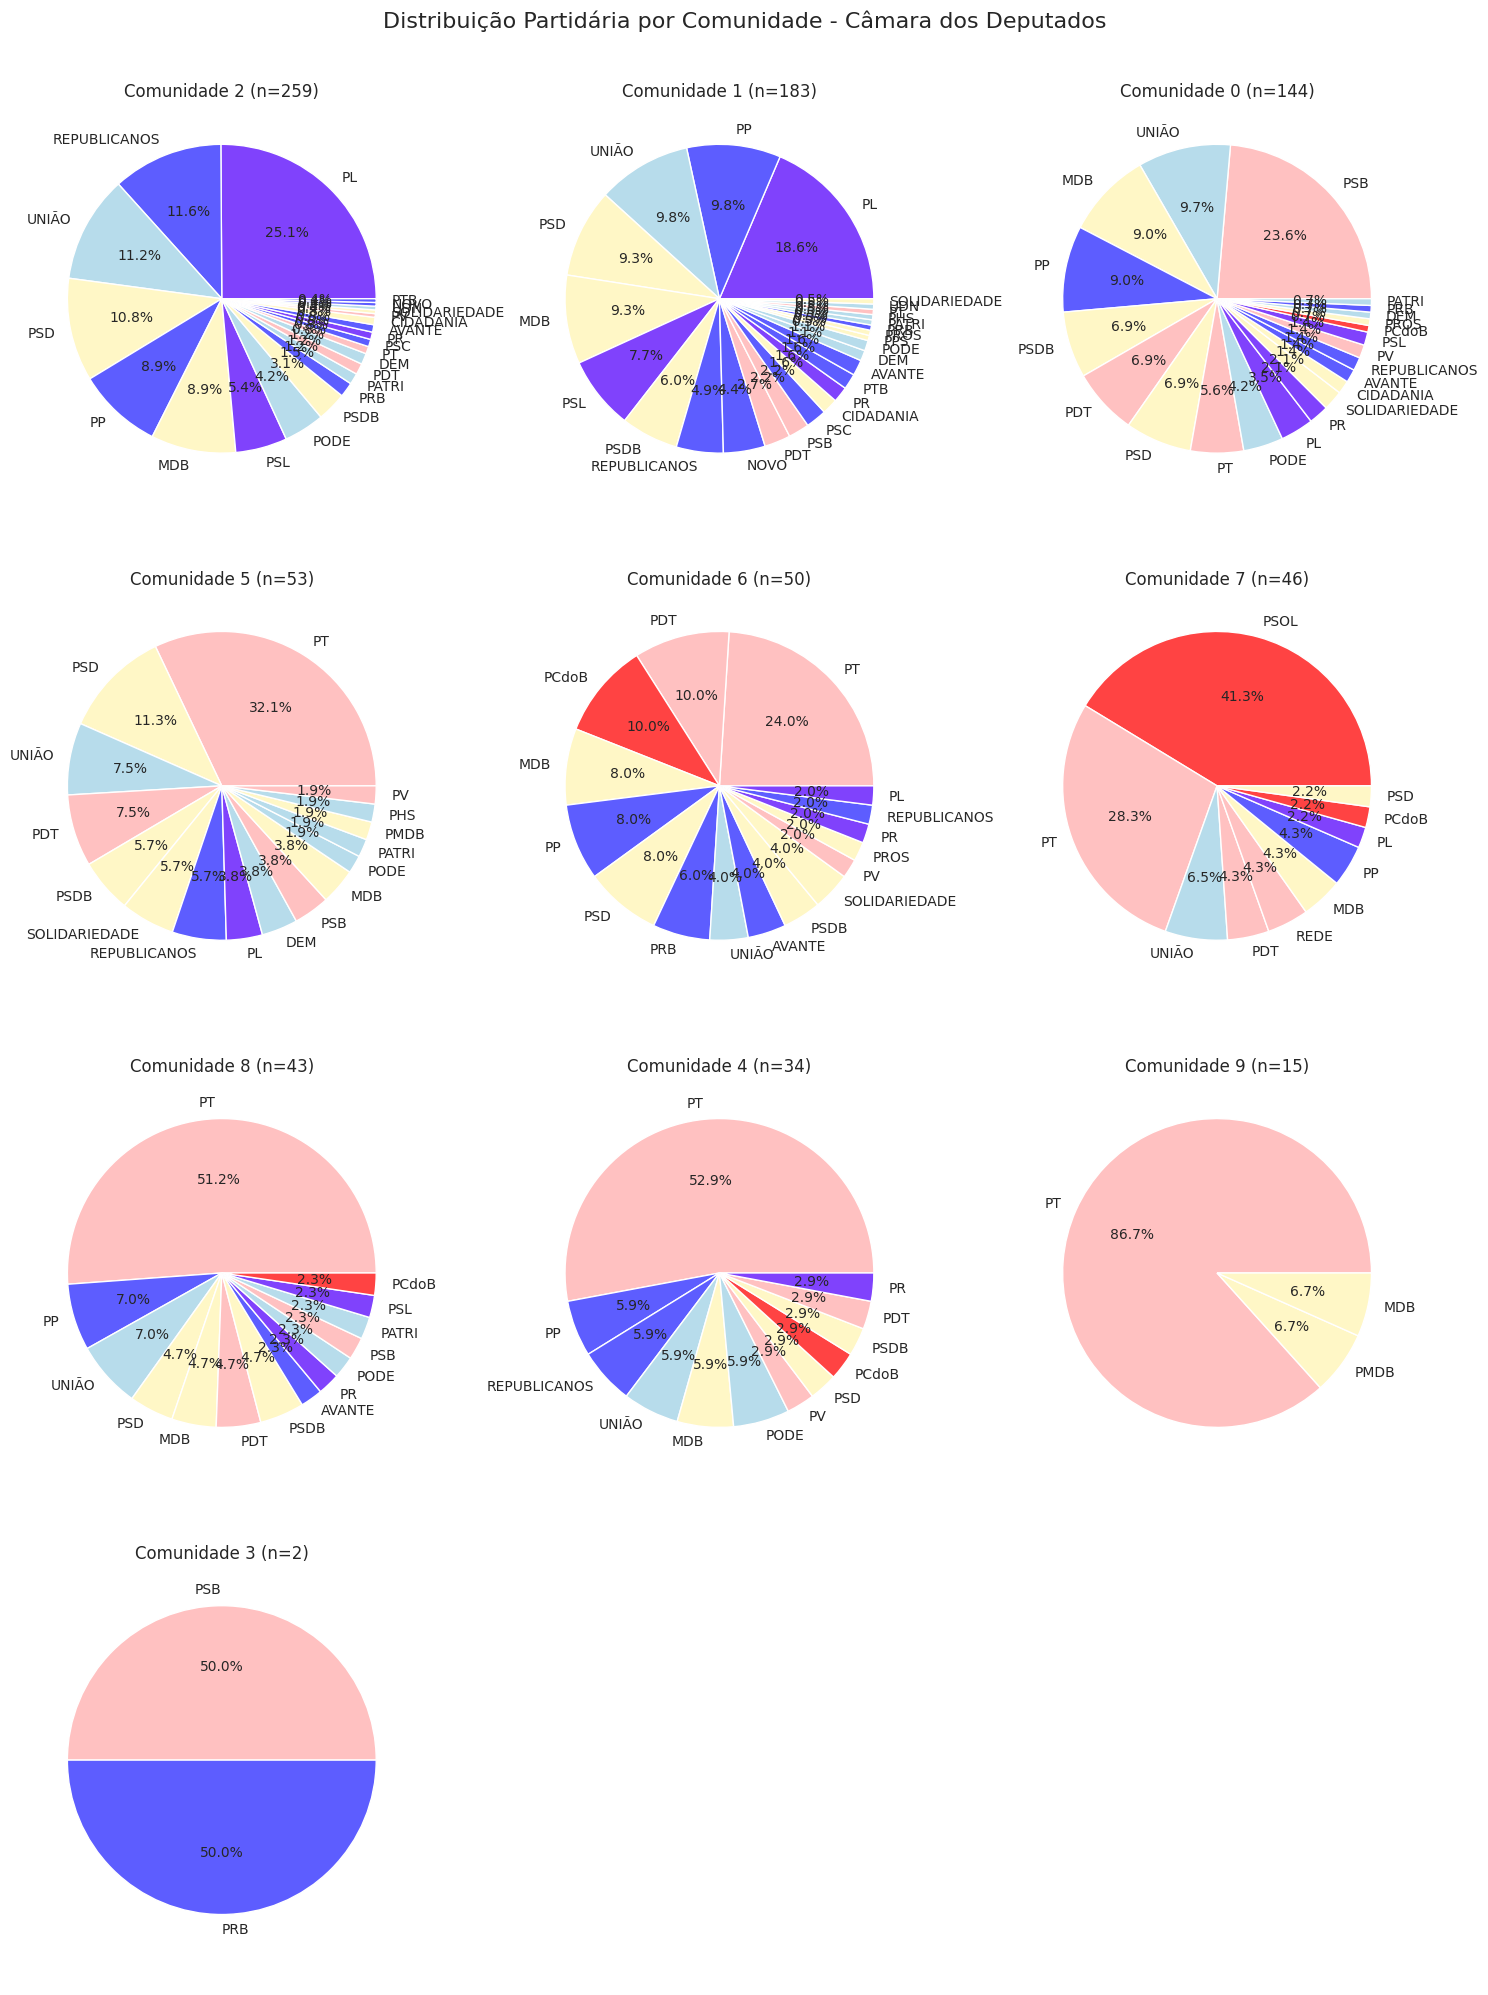

In [14]:
import matplotlib.pyplot as plt

ideology_colors = {
    'left': "#FF4343",
    'centre-left': "#FFC1C1",
    'centre': "#FFF7C6",
    'centre-right': "#B7DCEB",
    'right': "#5D5DFF",
    'far-right': "#8042FC"
}

# Create a figure with subplots for each community
n_communities = len(house_comm_df)
n_cols = 3  # Number of columns in subplot grid
n_rows = (n_communities + n_cols - 1) // n_cols  # Calculate needed rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_communities > 1 else [axes]

fig.suptitle('Distribuição Partidária por Comunidade - Câmara dos Deputados', fontsize=16, y=0.995)

for idx, (comm_id, row) in enumerate(house_comm_df.iterrows()):
    party_dict = row['party']
    
    # Sort by count for better visualization
    sorted_parties = dict(sorted(party_dict.items(), key=lambda x: x[1], reverse=True))
    colors = [ideology_colors.get(ideol_by_party.get(party, ''), '#CCCCCC') 
              for party in sorted_parties.keys()]
    ax = axes[idx]
    ax.pie(sorted_parties.values(), labels=sorted_parties.keys(), autopct='%1.1f%%', colors=colors)
    ax.set_title(f'Comunidade {comm_id} (n={row["size"]})')

# Hide any unused subplots
for idx in range(n_communities, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Índice Gini por partido**

In [15]:
house_pivot_df = house_node_df.pivot_table(
    columns='leiden_mod',
    index='cod_partido',
    aggfunc='size',
    fill_value=0
)
house_pivot_df

leiden_mod,0,1,2,3,4,5,6,7,8,9
cod_partido,,,,,,,,,,
AVANTE,2,3,2,0,0,0,2,0,1,0
CIDADANIA,2,3,2,0,0,0,0,0,0,0
DEM,1,2,3,0,0,2,0,0,0,0
MDB,13,17,23,0,2,2,4,2,2,1
NOVO,0,8,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
REDE,0,0,0,0,0,0,0,2,0,0
REPUBLICANOS,2,9,30,0,2,3,1,0,0,0
SOLIDARIEDADE,3,1,1,0,0,3,2,0,0,0


Vejamos como os maiores partidos se comportam. Aqui estamos pensando num índice Gini "inverso", ou seja, quanto maior a área abaixo da diagonal, mais coeso o partido é.

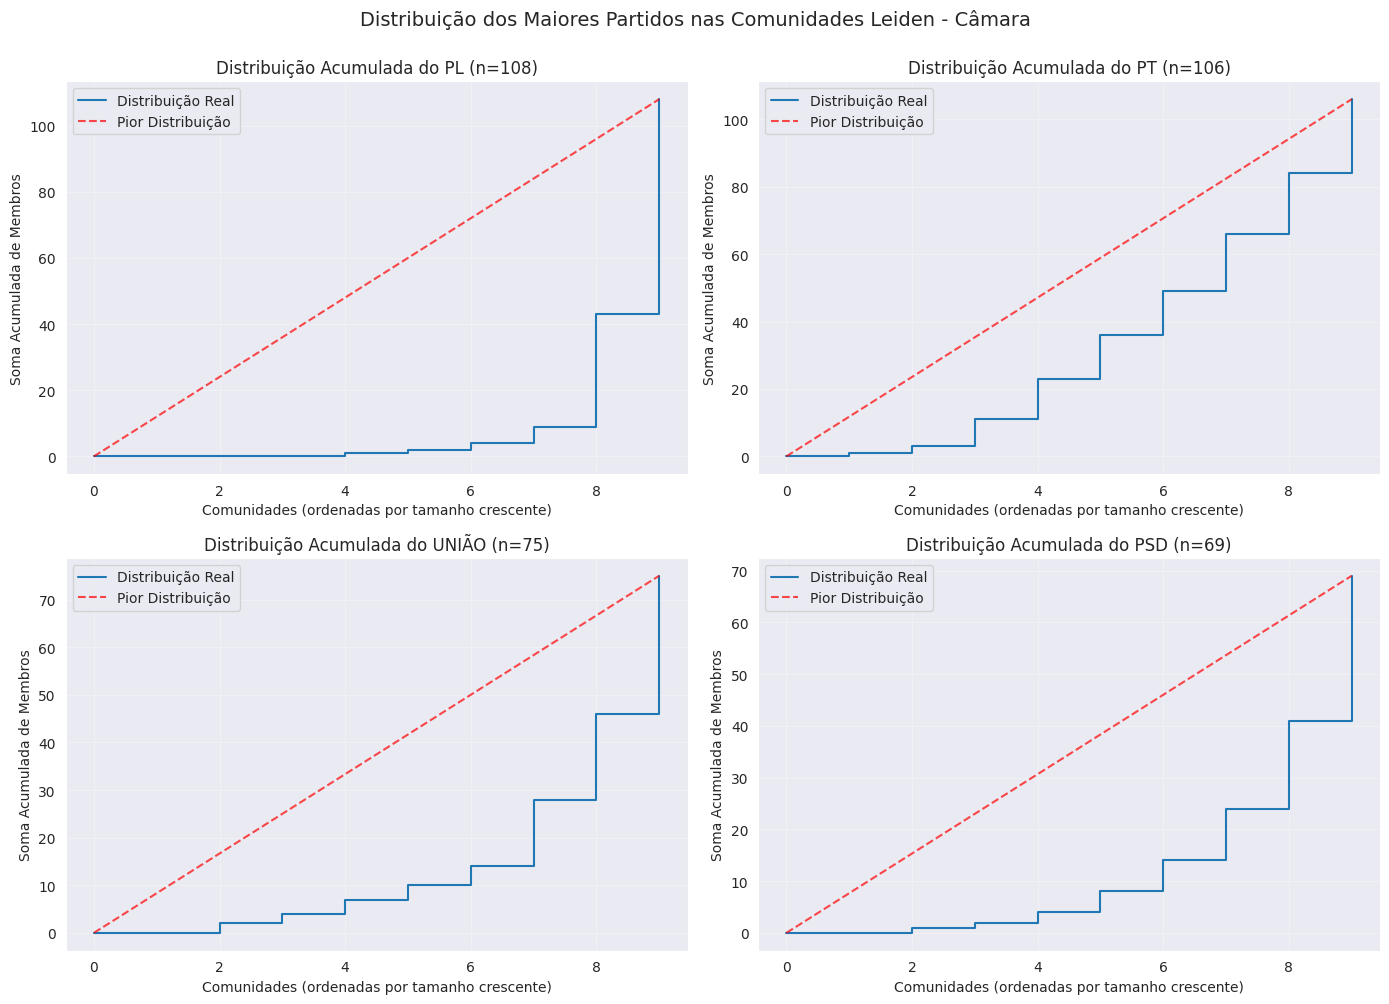

In [16]:
biggest_parties = house_node_df.value_counts('cod_partido', ascending=False)[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (party_name, party_count) in enumerate(biggest_parties.items()):
    ax = axes[idx]
    
    party_sorted = house_pivot_df.loc[party_name, :].sort_values()
    party_cumsum = party_sorted.cumsum()
    
    ax.step(range(len(party_cumsum)), party_cumsum.values, where='post', label='Distribuição Real')
    ax.plot([0, len(party_cumsum) - 1], [0, party_cumsum.iloc[-1]], 
            linestyle='--', color='red', alpha=0.7, label='Pior Distribuição')
    ax.set_xlabel('Comunidades (ordenadas por tamanho crescente)')
    ax.set_ylabel('Soma Acumulada de Membros')
    ax.set_title(f'Distribuição Acumulada do {party_name} (n={party_count})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribuição dos Maiores Partidos nas Comunidades Leiden - Câmara', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

Vemos que na Câmara, o PL aparenta ser mais coeso em termos de sua distribuição em comunidades, enquanto o PT é mais difuso.

Vamos agora calcular os índices para todos os partidos.

In [17]:
house_pivot_normalized_df = house_pivot_df.div(house_pivot_df.sum(axis=1), axis=0)
house_pivot_normalized_df

leiden_mod,0,1,2,3,4,5,6,7,8,9
cod_partido,,,,,,,,,,
AVANTE,0.200000,0.300000,0.200000,0.0,0.000000,0.000000,0.200000,0.000000,0.100000,0.000000
CIDADANIA,0.285714,0.428571,0.285714,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DEM,0.125000,0.250000,0.375000,0.0,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000
MDB,0.196970,0.257576,0.348485,0.0,0.030303,0.030303,0.060606,0.030303,0.030303,0.015152
NOVO,0.000000,0.888889,0.111111,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
REDE,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
REPUBLICANOS,0.042553,0.191489,0.638298,0.0,0.042553,0.063830,0.021277,0.000000,0.000000,0.000000
SOLIDARIEDADE,0.300000,0.100000,0.100000,0.0,0.000000,0.300000,0.200000,0.000000,0.000000,0.000000


In [18]:
house_gini = house_pivot_normalized_df.apply(get_gini, axis=1)
house_gini

cod_partido
AVANTE           0.644
CIDADANIA        0.810
DEM              0.750
MDB              0.640
NOVO             0.975
                 ...  
REDE             1.000
REPUBLICANOS     0.839
SOLIDARIEDADE    0.689
UDN              0.889
UNIÃO            0.671
Length: 31, dtype: float64

In [19]:
house_gini.sort_values(ascending=False)

cod_partido
PPS     1.000
REDE    1.000
PSOL    1.000
NOVO    0.975
PTB     0.944
        ...  
MDB     0.640
PV      0.630
PR      0.616
PDT     0.528
PT      0.428
Length: 31, dtype: float64

### 5.2.3. Senado Federal


Vamos reproduzir essas métricas agora para o Senado Federal.

In [20]:
senate_comm_df = senate_node_df.groupby('leiden_mod').agg(
    size=('leiden_mod', 'size'),
    author_type=('type', lambda x: x.value_counts().to_dict()),
    party=('cod_partido', lambda x: x.value_counts().to_dict()),
    ideology=('ideol_partido', lambda x: x.value_counts().to_dict()),
    region=('regiao', lambda x: x.value_counts().to_dict()),
    state=('uf', lambda x: x.value_counts().to_dict()),
).sort_values('size', ascending=False)[['size', 'party', 'ideology']]

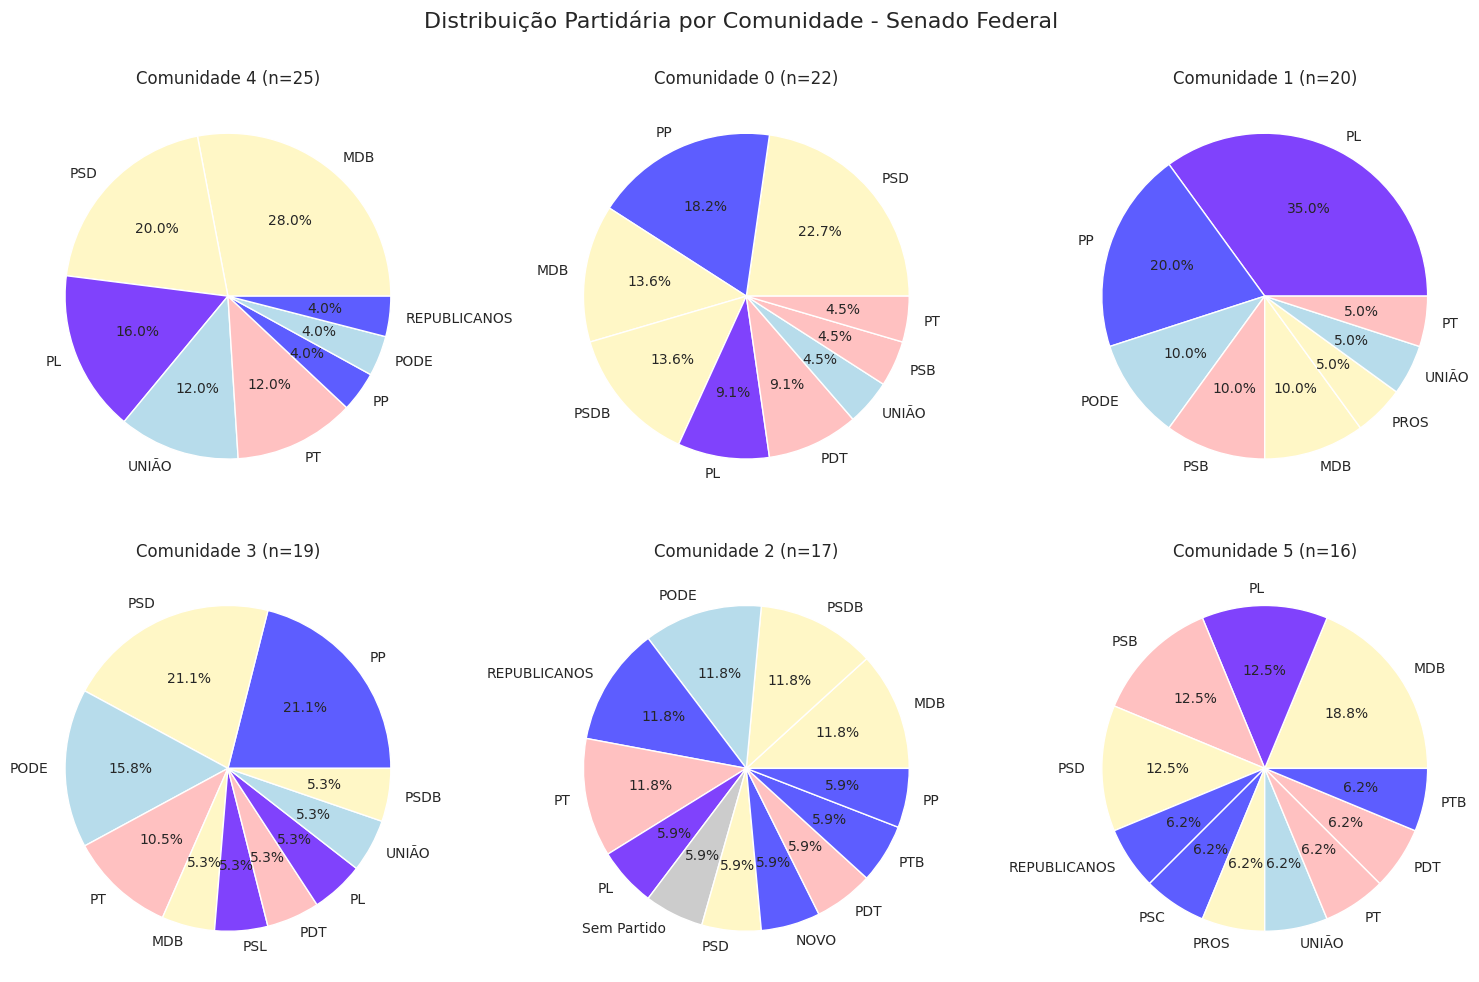

In [21]:
import matplotlib.pyplot as plt

ideology_colors = {
    'left': "#FF4343",
    'centre-left': "#FFC1C1",
    'centre': "#FFF7C6",
    'centre-right': "#B7DCEB",
    'right': "#5D5DFF",
    'far-right': "#8042FC"
}

# Create a figure with subplots for each community
n_communities = len(senate_comm_df)
n_cols = 3  # Number of columns in subplot grid
n_rows = (n_communities + n_cols - 1) // n_cols  # Calculate needed rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_communities > 1 else [axes]

fig.suptitle('Distribuição Partidária por Comunidade - Senado Federal', fontsize=16, y=0.995)

for idx, (comm_id, row) in enumerate(senate_comm_df.iterrows()):
    party_dict = row['party']
    
    # Sort by count for better visualization
    sorted_parties = dict(sorted(party_dict.items(), key=lambda x: x[1], reverse=True))
    colors = [ideology_colors.get(ideol_by_party.get(party, ''), '#CCCCCC') 
              for party in sorted_parties.keys()]
    ax = axes[idx]
    ax.pie(sorted_parties.values(), labels=sorted_parties.keys(), autopct='%1.1f%%', colors=colors)
    ax.set_title(f'Comunidade {comm_id} (n={row["size"]})')

# Hide any unused subplots
for idx in range(n_communities, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Índice Gini por partido**

In [22]:
senate_node_df.value_counts('cod_partido')

cod_partido
MDB             18
PL              17
PSD             17
PP              14
PT              10
PODE             8
UNIÃO            7
PSDB             6
PDT              5
PSB              5
REPUBLICANOS     4
PROS             2
PTB              2
PSC              1
NOVO             1
PSL              1
Sem Partido      1
Name: count, dtype: int64

In [23]:
senate_pivot_df = senate_node_df.pivot_table(
    columns='leiden_mod',
    index='cod_partido',
    aggfunc='size',
    fill_value=0
)
senate_pivot_df

leiden_mod,0,1,2,3,4,5
cod_partido,,,,,,
MDB,3,2,2,1,7,3
NOVO,0,0,1,0,0,0
PDT,2,0,1,1,0,1
PL,2,7,1,1,4,2
PODE,0,2,2,3,1,0
PP,4,4,1,4,1,0
PROS,0,1,0,0,0,1
PSB,1,2,0,0,0,2
PSC,0,0,0,0,0,1


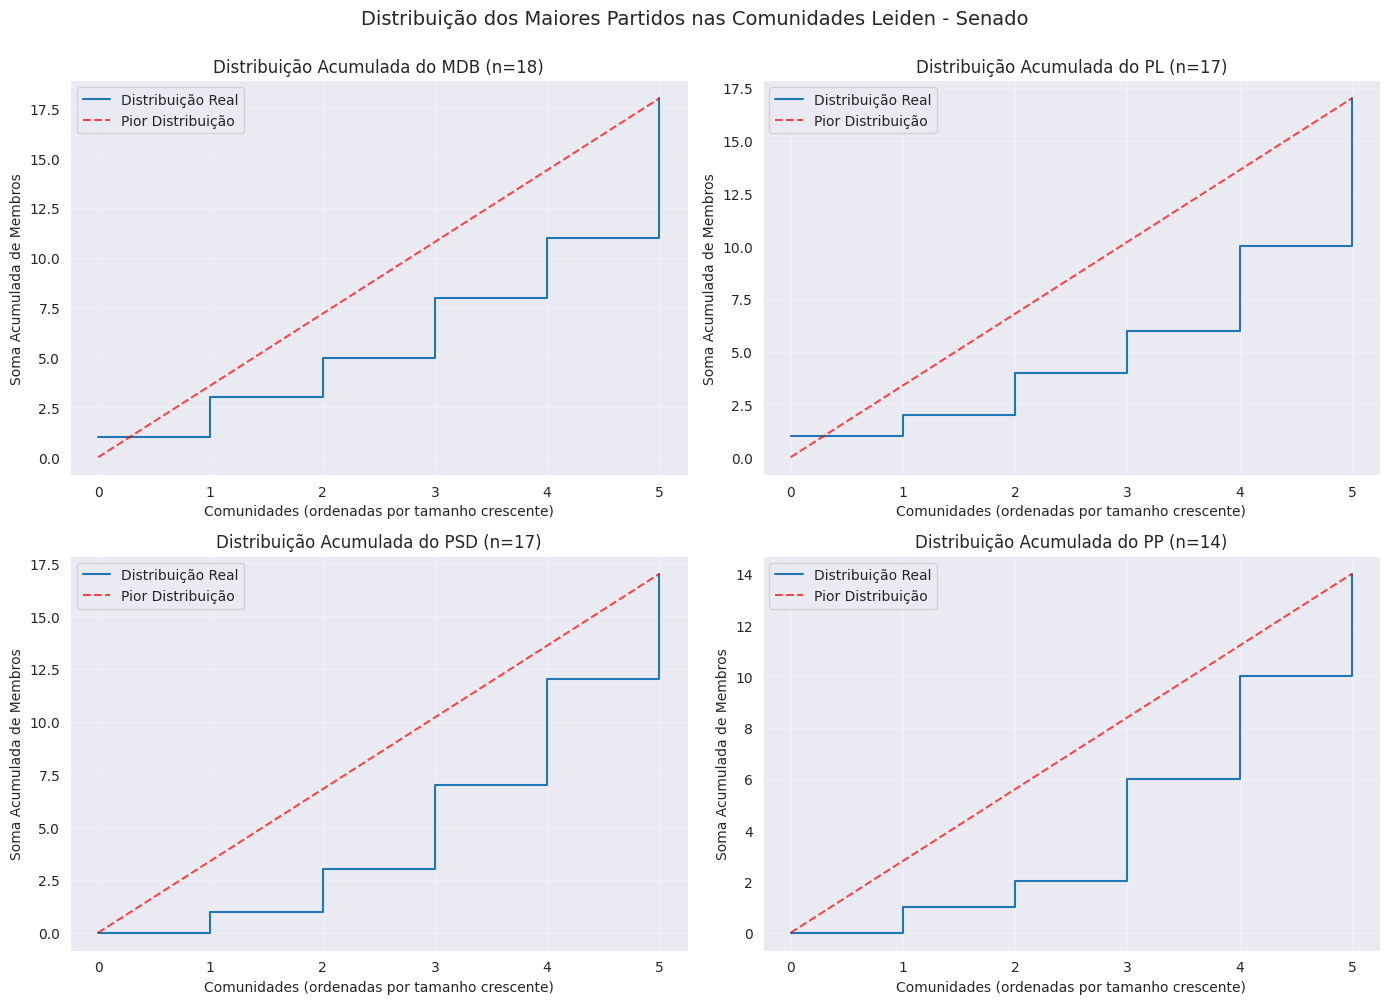

In [24]:
biggest_parties = senate_node_df.value_counts('cod_partido', ascending=False)[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (party_name, party_count) in enumerate(biggest_parties.items()):
    ax = axes[idx]
    
    party_sorted = senate_pivot_df.loc[party_name, :].sort_values()
    party_cumsum = party_sorted.cumsum()
    
    ax.step(range(len(party_cumsum)), party_cumsum.values, where='post', label='Distribuição Real')
    ax.plot([0, len(party_cumsum) - 1], [0, party_cumsum.iloc[-1]], 
            linestyle='--', color='red', alpha=0.7, label='Pior Distribuição')
    ax.set_xlabel('Comunidades (ordenadas por tamanho crescente)')
    ax.set_ylabel('Soma Acumulada de Membros')
    ax.set_title(f'Distribuição Acumulada do {party_name} (n={party_count})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribuição dos Maiores Partidos nas Comunidades Leiden - Senado', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

In [25]:
senate_pivot_normalized_df = senate_pivot_df.div(senate_pivot_df.sum(axis=1), axis=0)
senate_pivot_normalized_df

leiden_mod,0,1,2,3,4,5
cod_partido,,,,,,
MDB,0.166667,0.111111,0.111111,0.055556,0.388889,0.166667
NOVO,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
PDT,0.400000,0.000000,0.200000,0.200000,0.000000,0.200000
PL,0.117647,0.411765,0.058824,0.058824,0.235294,0.117647
PODE,0.000000,0.250000,0.250000,0.375000,0.125000,0.000000
PP,0.285714,0.285714,0.071429,0.285714,0.071429,0.000000
PROS,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000
PSB,0.200000,0.400000,0.000000,0.000000,0.000000,0.400000
PSC,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [26]:
senate_gini = senate_pivot_normalized_df.apply(get_gini, axis=1)
senate_gini

cod_partido
MDB             0.378
NOVO            1.000
PDT             0.520
PL              0.459
PODE            0.550
PP              0.457
PROS            0.800
PSB             0.680
PSC             1.000
PSD             0.459
PSDB            0.733
PSL             1.000
PT              0.280
PTB             0.800
REPUBLICANOS    0.700
Sem Partido     1.000
UNIÃO           0.429
dtype: float64

In [27]:
senate_gini.sort_values(ascending=False)

cod_partido
NOVO            1.000
Sem Partido     1.000
PSC             1.000
PSL             1.000
PROS            0.800
PTB             0.800
PSDB            0.733
REPUBLICANOS    0.700
PSB             0.680
PODE            0.550
PDT             0.520
PSD             0.459
PL              0.459
PP              0.457
UNIÃO           0.429
MDB             0.378
PT              0.280
dtype: float64